# TransientAsciiMetric

This notebook demonstrates how to use the TransientAsciiMetric, which lets you use an ascii file to specify a lightcurve template, and then either calculate the likelihood of detecting a transient with that lightcurve or generate the actual lightcurve datapoints.

In [1]:
#    import maf packages
import numpy as np
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
import healpy as hp
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots

from mafContrib import TransientAsciiMetric

First do some bookkeeping: connect to the opsim database and set up the output directory and resultsDb.

In [4]:
# Set the database and query
runName = 'minion_1016'
opsdb = db.OpsimDatabase('../' + runName + '_sqlite.db')

# Set the output directory
outDir = 'Transients'
resultsDb = db.ResultsDb(outDir)

Set up the transient ascii metric.  

Note that if `dataout` is True, the output at each slicePoint will be a dictionary of: 
 'lcNumber', 'expMJD', 'epoch', 'filter', 'lcMag', 'SNR', 'detected' (a flag indicating whether that lightcurve met the detection criteria). 
If `dataout` is False, the output at each slicePoint will be the likelihood of detecting a transient with this lightcurve.

In [5]:
asciiLC = '2013ab_1.dat'
transMetric = TransientAsciiMetric(asciiLC, surveyDuration=1, 
                                   detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5},
                                   nPreT=0, preT=0, nFilters=0, filterT=None, nPerLC=0, peakOffset=0,
                                   dataout=True)

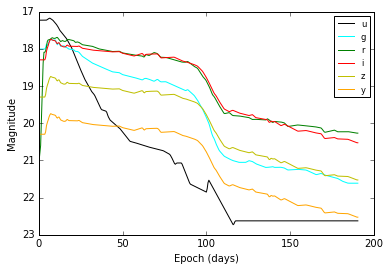

In [18]:
# Use the metric to generate a tightly sampled lightcurve, to illustrate what the lightcurve looks like.
filterNames = ['u', 'g', 'r', 'i', 'z', 'y']
colors = {'u': 'k', 'g': 'cyan', 'r': 'g', 'i': 'r', 'z': 'y', 'y': 'orange'}
times = np.arange(0, transMetric.transDuration, 0.5)
lc = {}
for f in filters:
    lc[f] = transMetric.make_lightCurve(times, np.array([f]*len(times)))

plt.figure()
for f in filterNames:
    plt.plot(times, lc[f], color=colors[f], label=f)
plt.ylim(23, 17)
plt.xlabel('Epoch (days)')
plt.ylabel('Magnitude')
plt.legend(fontsize='smaller', numpoints=1)

Set up the slicer and sql constraint, assign them all to a metricBundle.

In [7]:
# Slicer - we just want to look at what the full lightcurve output looks like, so choose a few representative points.
# With the UserPointsSlicer, you can set ra/dec for the places you want to evaluate.
# These ra/dec pairs are 1 DD field and 3 WFD fields.
ra = np.array([0.600278, 1.284262, 1.700932, 1.656778])
dec = np.array([-0.088843, 0.00327, -0.65815, -0.323526])
slicer = slicers.UserPointsSlicer(ra, dec)

# SQL constraint.
# select the of the survey that you want to run 
year = 9
sqlconstraint = 'night between %f and %f '% ((365.25*year,365.25*(year+1)))

lightcurve_metric = metricBundles.MetricBundle(transMetric, slicer, sqlconstraint, runName=runName)

In [8]:
# run the metric
bgroup = metricBundles.MetricBundleGroup({0: lightcurve_metric}, opsdb, 
                                         outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database with constraint night between 3287.250000 and 3652.500000 
Found 226370 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plot each of the lightcurves created by setting off a set of back-to-back transients at each of the slicePoints. Note that not every slicePoint is sampled equally in time, especially since we only looked at one year. 

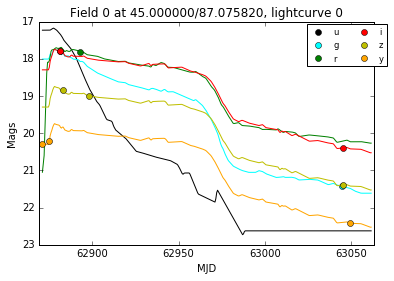

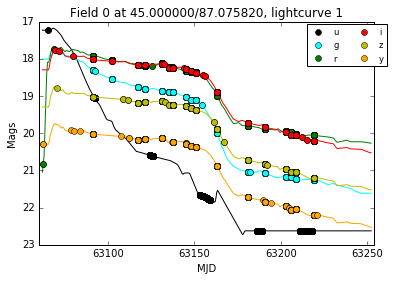

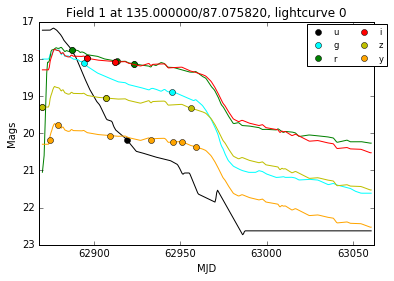

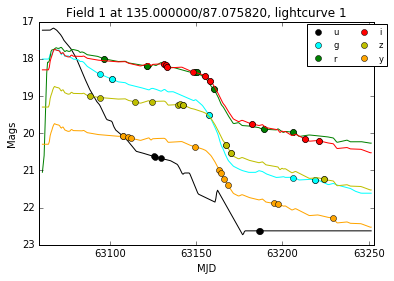

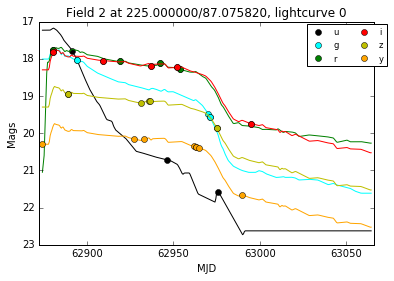

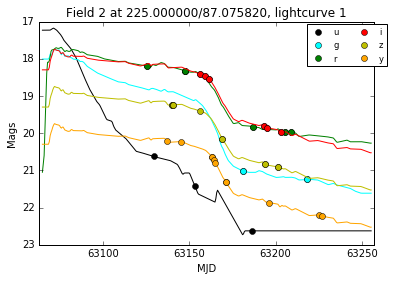

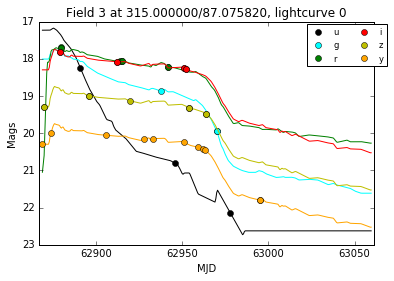

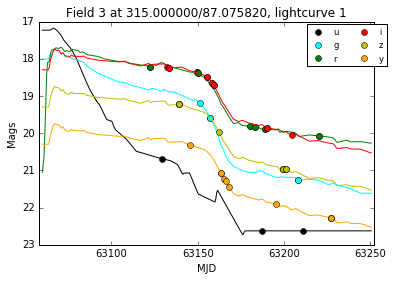

In [34]:
for i, data in enumerate(lightcurve_metric.metricValues):
    for lcN in np.unique(data['lcNumber']):
        match = np.where(data['lcNumber'] == lcN)
        plt.figure()
        epoch = data['epoch'][match]
        mjd = data['expMJD'][match]
        mags = data['lcMag'][match]
        filters = data['filter'][match]
        for f in filterNames:
            filtermatch = np.where(filters == f)
            plt.plot(times - epoch[0] + mjd[0], lc[f], color=colors[f])
            plt.plot(mjd[filtermatch], mags[filtermatch], 'o', color=colors[f], label=f)
        plt.ylim(plt.ylim()[::-1])
        plt.xlim(times[0] - epoch[0] + mjd[0] - 2, times[0] - epoch[0] + mjd[0] + 192)
        plt.legend(ncol = 2, loc = (.8,.8), numpoints=1, fontsize='smaller') 
        plt.xlabel('MJD')
        plt.ylabel('Mags')
        plt.title('Field %d at %f/%f, lightcurve %d' % (i, np.degrees(slicer.slicePoints['ra'][i]), 
                                                        np.degrees(slicer.slicePoints['dec'][i]), lcN))
        plt.show()

Now let's look at the metric, with dataout = False. In this case, it calculates the likelihood of detecting a transient at each slicePoint. We can also add some additional detection criteria.

In [26]:
metric = TransientAsciiMetric(asciiLC, surveyDuration=1, 
                              detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5},
                              nPreT=3, preT=5, nFilters=3, filterT=30, nPerLC=2, peakOffset=0,
                              dataout=False)
slicer = slicers.HealpixSlicer(nside=16)
year = 8
sqlconstraint = 'night between %d and %d' % (365.25 * year, 365.25 * (year + 2))

plotFuncs = [plots.HealpixSkyMap(), plots.HealpixHistogram()]
plotDict = {'colorMin': 0, 'colorMax': 1}

summaryMetrics = [metrics.MeanMetric(), metrics.RmsMetric()]

bundle = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                    runName=runName, summaryMetrics=summaryMetrics,
                                    plotDict=plotDict, plotFuncs=plotFuncs)

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [27]:
bundlegroup = metricBundles.MetricBundleGroup({0: bundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
bundlegroup.runAll()

Querying database with constraint night between 2922 and 3652
Found 470681 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with night between 2922 and 3652 sqlconstraint now.
Plotting complete.


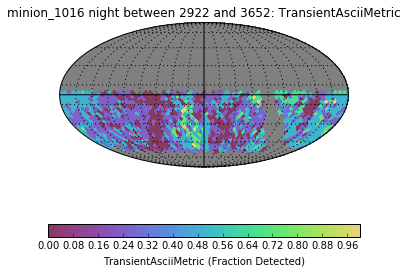

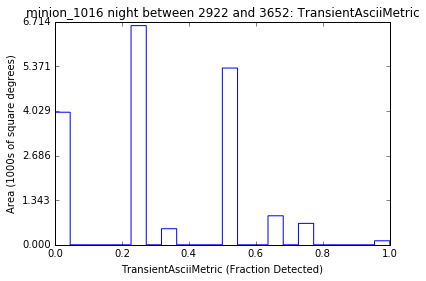

In [30]:
bundlegroup.plotAll(closefigs=False)

In [32]:
print bundle.summaryValues

{'Rms': 0.22252416334040515, 'Mean': 0.31377297565822154}
